In [561]:
import pdb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import pdb
import warnings
warnings.filterwarnings("ignore")


In [499]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1")
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()

In [125]:
# structure learning part of the algorithm

import numpy as np
from numpy.random import sample
import numpy.linalg as la

# can we replace this with a clustering algorithm?

def learnStructure(X, L0, eps, H, T, ar0, aw0):
    """
        X is the data to cluster
        L0 initial number of clusters
        eps threshold
        T max iterations
        h convergence parameter
        ar0, aw0 learning rates
        
        returns learned centers of data
    """
    wins = np.ones((1,L0))
    centers = X[np.random.choice(X.shape[0], L0, replace=False), :]
    
    h = 0
    while h<H :
        #print("****** h = {} ******" .format(h))
        t = 0
        L = len(centers)
        while t<T:
            # select a random sample
            z = X[np.random.choice(X.shape[0], 1), :]
            # compute its distance to all centers
            distances = np.multiply(wins/np.sum(wins),la.norm(centers - np.ones((L,1)).dot(z), axis = 1))
    
            # compute min and its rival
            w = np.argmin(distances)
            r = np.argmin(np.delete(distances,w))

            # update centers
            centers[w,:] = centers[w,:] + aw0*(1-t/T)*(z - centers[w,:])
            centers[r,:] = centers[r,:] - ar0*(1-t/T)*(z - centers[r,:])
            wins[0,w] += 1
            t += 1


        # compute clusters for each sample and the number of samples in each cluster
        clusters = np.zeros((1,X.shape[0]))
        ratios = np.zeros((1,L))

        for i in range(X.shape[0]):
            z = X[np.array([i]),:]
            distances = np.multiply(wins/np.sum(wins),la.norm(centers - np.ones((L,1)).dot(z), axis = 1))
            k = np.argmin(distances)
            clusters[0,i] = k
            ratios[0,k] += 1

        # compute ratios
        ratios = ratios / X.shape[0]


        # delete clusters with ratios  less than threshold
        indexes = np.argwhere( ratios < eps)[:,1]
        if len(indexes) >= eps : h += 1
        centers = np.delete(centers, indexes, axis = 0)
        wins = np.delete(wins, indexes, axis = 1)

    return centers
    
    
        
        

In [151]:
# simple test
X = 20*np.random.randn(100,2)

ar0 = 0.01
aw0 = 0.1
T = 30
eps = 0.1
H = 3
L0 = 10
centers =learnStructure(X, L0, eps, H, T, ar0, aw0)



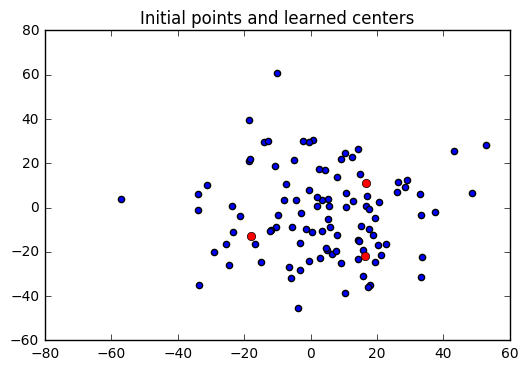

In [155]:
plt.scatter(X[:,0],X[:,1])
plt.hold()
plt.plot(centers[:,0],centers[:,1], 'ro', color = 'red')
plt.title('Initial points and learned centers (red)')

In [137]:
L0 = 2

X = np.array([[1,2,3],[1,2,3]])
wins = np.ones((1,L0))
centers = X[np.random.choice(X.shape[0], L0, replace=False), :]
z = X[np.random.choice(X.shape[0], 1), :]
distances = la.norm(centers - np.ones((L0,1)).dot(z), axis = 1)
distances = np.multiply(wins/np.sum(wins),la.norm(centers - np.ones((L0,1)).dot(z), axis = 1))
np.delete(distances,0)
distances[0,:] = distances[0,:] +1  
distances[distances == 0]
np.delete(X, np.argwhere(distances > 0)[:,1], axis = 1)
np.random.choice(X.shape[0], 1)


array([0])

In [479]:
from sklearn.neighbors import NearestNeighbors


def gaussian(x, mu, sigma):
    return np.exp( -(x-mu)**2 / sigma**2 )


class Membership:
    def __init__(self, fun, **parameters):
        self.fun = fun
        self.parameters = parameters
           
    def apply(self, x):
        return self.fun(x, **self.parameters)
    
    def update(self,*params):
        pass
    
    def setParams(self,**params):
        for key in self.parameters:
            self.parameters[key] = params[key]

    
class RBF(Membership):
    def __init__(self, sigma = 1, mu =0):
        params = dict()
        params['sigma'] = sigma
        params['mu'] = mu
        super(RBF,self).__init__(gaussian, **params)
        
    def update(self,x,y,yhat,w,Sum,Prod,index,eta):
        deltaMu = np.sum(2/self.parameters['sigma']**2 * 
                         np.multiply(Prod, 
                                     np.multiply((x[:,index] - self.parameters['mu']),
                                                       np.multiply(yhat-y,-yhat + w))))
        deltaSigma = np.sum(2/self.parameters['sigma']**3 
                            * np.multiply(Prod, 
                                          np.multiply((x[:,index] - self.parameters['mu'])**2,
                                                      np.multiply(yhat-y,-yhat + w))))
        self.parameters['mu'] = self.parameters['mu'] - eta * deltaMu
        self.parameters['sigma'] = self.parameters['sigma'] - eta * deltaSigma

class Rule:
    def __init__(self, Membership, ninputs):
        self.members = []
        self.ninputs = ninputs
        self.mmebership = Membership
        for i in range(ninputs):
            m = Membership()
            self.members.append(m)
            
    def apply(self, x):
        result = np.zeros((x.shape[0],1))
        for i in range(x.shape[0]):
            r = 1
            for j in range(self.ninputs):
                r *= self.members[j].apply(x[i,j])
            result[i,0] = r
        return result
    
    def update(self,*params):
        pass
    
    
    def setParams(self,paramsList):
        for i in range(self.ninputs):
            self.members[i].setParams(**(paramsList[i]))
            
            
class RBFRule(Rule):
    def __init__(self, ninputs):
        super(RBFRule, self).__init__(RBF,ninputs)
        
    def update(self,x,y,yhat,w,Sum,eta):
        Prod = self.apply(x)
        for i in range(self.ninputs):
            self.members[i].update(x,y,yhat,w,Sum,Prod,i,eta)
            
    
class FuzzyLayer:
    def __init__(self, Membership, ninputs, nrules):
        self.rules = []
        self.total = 1
        self.nrules = nrules
        self.ninputs = ninputs
        for i in range(self.nrules):
            self.rules.append(Rule(Membership, self.ninputs))

    def apply(self, x):
        result = np.zeros((x.shape[0],self.nrules))
        self.total = np.zeros((x.shape[0],1))
        for i in range(self.nrules):
            r = self.rules[i].apply(x) 
            result[:,i] = r[:,0]
            self.total += r
        return np.divide(result, self.total.dot(np.ones((1,self.nrules))))
    
    def update(self,*params):
        pass
    
        
                
class RBFFuzzyLayer(FuzzyLayer):
    def __init__(self, ninputs, nrules):
        super(RBFFuzzyLayer, self).__init__(RBF, ninputs, nrules)
        
        
    def update(self,x,y,yhat,w,eta):
        r = self.apply(x)
        Sum = self.total
        for i in range(self.nrules):
            self.rules[i].update(self,x,y,yhat,w[i],Sum,eta)
            
            
class NeuralNetwork:
    def __init__(self, ninputs):
        self.ninputs = ninputs
        self.weights = np.zeros((self.ninputs,1))
        
    def apply(self,x):
        return np.sum(x.dot(self.weights), 1)
    
    def update(self,x,y,yhat,eta):
        n,m = self.weights.shape
        yhat = yhat.reshape(y.shape)
        delta = eta*np.sum(self.weights.dot((yhat-y).T),1)
        self.weights =  self.weights - eta*np.sum(self.weights.dot((yhat-y).T),1).reshape(n,m)
        
    def setParams(self, weights):
        self.weights = weights
        
        

class SOFNN: 
    def __init__(self, ninitRules=10, eps=0.1, iterations=2, T=30, rrate=0.01, wrate=0.1, overlap =1.5 ):
        self.fuzzyLayer = None
        self.neuralNetwork = None
        self.ninitRules = ninitRules
        self.eps = eps
        self.iterations = iterations
        self.T = T
        self.rrate = rrate
        self.wrate = wrate
        self.centers = None
        self.overlap = overlap
        

    def fit(self,X,Y):
        D = np.concatenate((X,Y),1)
        self.centers = learnStructure(D, self.ninitRules, self.eps, self.iterations, self.T, self.rrate, self.wrate)
        params = self.centers[:,0:-1]
        weights = self.centers[:,-1:]
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(params)
        nrules,ninputsp1 = self.centers.shape
        ninputs = ninputsp1 -1
        self.fuzzyLayer = RBFFuzzyLayer(ninputs,nrules)
        self.neuralNetwork = NeuralNetwork(nrules)
        
        self.neuralNetwork.setParams(weights)
        
        for i in range(nrules):
            mus = params[i,:]
            sigmas = np.abs(params[i,:]-params[nbrs.kneighbors(params[i,:])[1][:,1],:]) / self.overlap
            sigmas = sigmas.flatten()
            d = [{'mu':mus[k],'sigma':sigmas[k]} for k in range(ninputs)]
            (self.fuzzyLayer.rules[i]).setParams(d)
            
    def apply(self, X):
        temp = self.fuzzyLayer.apply(X)
        return self.neuralNetwork.apply(temp)
            
            
    def train(self, X, Y, batchSize = 1, epochs = 1, eta=0.1):
        for _ in range(epochs):
            for _ in range(int(X.shape[0]/batchSize)):
                indexes = np.random.choice(X.shape[0], batchSize)
                x = X[indexes]
                y = Y[indexes]
                yhat = self.apply(x)
                self.neuralNetwork.update(self.fuzzyLayer.apply(x),y,yhat,eta)
                self.fuzzyLayer.update(x,y,yhat,self.neuralNetwork.weights,eta)
                
    def predict(self, X):
        return self.apply(X)
        
        

        


In [400]:
# tests

a = np.array([[4]])
print(a[:,0])

m = RBF(sigma = 1, mu =0)
m.apply(0)
m.update(np.array([[4]]),np.array([[4]]),np.array([[4]]),4,np.array([[4]]),np.array([[4]]),0,0.1)

r = RBFRule(3)

x =  np.random.randn(10,3)
y = np.random.randn(10,1)
yhat = np.random.randn(10,1)
Sum = np.random.randn(10,1)
r.apply(x)
r.update(x,y,yhat,3,Sum,0.1)



fr = RBFFuzzyLayer(3,10)
a = fr.apply(x)
fr.update(x,y,yhat,y,0.1)
print(a)



nn = NeuralNetwork(10)

b  = nn.apply(fr.apply(x))
print(b)

nn.update(fr.apply(x), y, yhat, 0.1)


[4]
[[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(10, 1)
(10, 1)
(10, 1)
(10,)


In [578]:
#D = np.random.randn(100,1)


#X = D[:,0:-1]
#Y = D[:,-1:]

X = np.array([range(100)]).T
Y = np.sin(1/12*3.14*X)

X = np.array([[float(X[i]), float(X[i+1]), float(X[i+2])] for i in range(X.shape[0]-3)])
Y = np.array([[float(Y[i+3]) for i in range(X.shape[0])]]).T


sofnn = SOFNN(ninitRules = 80, eps = 0.00001, rrate = 0.01, wrate = 0.2)
centers = sofnn.fit(X,Y)
sofnn.train(X,Y, batchSize = 2, epochs = 9, eta = 0.01)
yhat = sofnn.predict(X)

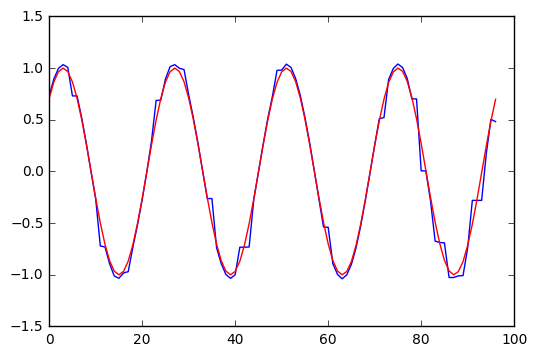

In [579]:
plt.plot(yhat,'blue',Y,'red')

In [569]:
# funciton approximation
X = 5/2 * (np.random.rand(100,3)+1) + 1
Y = np.array([[1+np.exp(0.5*np.log(X[i,0]))+np.exp(-1*np.log(X[i,1]))+np.exp(-1*np.log(X[i,2]))] for i in range(X.shape[0])])


sofnn = SOFNN(ninitRules = 100, eps = 0.0001, rrate = 0.01, wrate = 0.1)
centers = sofnn.fit(X,Y)

sofnn.train(X,Y, batchSize = 5, epochs = 10, eta = 0.01)
yhat = sofnn.predict(X)


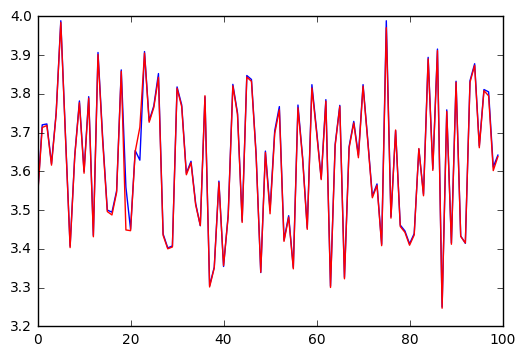

In [571]:
plt.plot(yhat,'blue',Y,'red')